In [1]:
# Importar de librerias para la construccion del modelo: TensorFlow y Keras
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras import layers, models, Sequential, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.utils import image_dataset_from_directory, load_img, img_to_array
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

# Librerías para preprocesamiento y métricas
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import psutil
import time

In [2]:
# Verificación de disponibilidad de GPU 
print("Versión de TensorFlow:", tf.__version__)
print("¿TensorFlow está usando GPU?")
print(tf.config.list_physical_devices('GPU'))

Versión de TensorFlow: 2.10.0
¿TensorFlow está usando GPU?
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# Diccionario de rutas
data_paths = {
    "Mel-512": "..\\Analisis_Espectros\\DataSetImages_FULL\\DataSetImages\\Spectrograms\\Mel-512",
    "Mel-1024": "..\\Analisis_Espectros\\DataSetImages_FULL\\DataSetImages\\Spectrograms\\Mel-1024",
    "Mel-2048": "..\\Analisis_Espectros\\DataSetImages_FULL\DataSetImages\\Spectrograms\\Mel-2048",
    "Bump": "..\\Analisis_Espectros\\DataSetImages_FULL\\DataSetImages\\Scalograms\\Bump",
    "Morlet": "..\\Analisis_Espectros\\DataSetImages_FULL\\DataSetImages\\Scalograms\\Morlet"  
}

In [4]:
def load_and_preprocess_data(data_path, batch_size=50, img_size=(224, 224)):
    # Cargar datasets de entrenamiento y validación
    raw_train_ds = tf.keras.utils.image_dataset_from_directory(
        data_path,
        validation_split=0.2,
        subset="training",
        seed=123,
        image_size=img_size,
        batch_size=batch_size
    )
    raw_val_ds = tf.keras.utils.image_dataset_from_directory(
        data_path,
        validation_split=0.2,
        subset="validation",
        seed=123,
        image_size=img_size,
        batch_size=batch_size
    )

    # Extraer nombres de las clases
    class_names = raw_train_ds.class_names

    # Normalizar los datos
    normalization_layer = tf.keras.layers.Rescaling(1.0 / 255)
    train_ds = raw_train_ds.map(lambda x, y: (normalization_layer(x), y))
    val_ds = raw_val_ds.map(lambda x, y: (normalization_layer(x), y))

    # Prefetch para optimizar
    train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

    return train_ds, val_ds, class_names

In [5]:
def create_model(num_classes):
    # Cargar VGG16 preentrenada
    base_model = VGG16(
        weights="imagenet",         # Pesos preentrenados en ImageNet
        include_top=False,          # Excluir las capas densas superiores
        input_shape=(224, 224, 3)   # Tamaño de entrada para VGG16
    )
    base_model.trainable = False   # Congelar las capas base

    # Añadir capas personalizadas
    model = models.Sequential([
        base_model,
        layers.Flatten(),          # VGG16 requiere aplanar las salidas
        layers.Dense(256, activation="relu"),  # Capa densa intermedia
        layers.Dropout(0.5),       # Regularización
        layers.Dense(num_classes, activation="softmax")  # Capa de salida
    ])
    return model

In [6]:
# Función para entrenar el modelo (Transfer Learning)
def train_model(model, train_ds, val_ds, epochs=30):
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=["accuracy"]
    )
    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
    ]
    history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=callbacks)
    return history

In [7]:
# Función para ajuste fino (Fine-Tuning)
def fine_tune_model(model, train_ds, val_ds, base_learning_rate=1e-4, fine_tune_at=9, epochs=60):
    # Descongelar la base del modelo
    model.layers[0].trainable = True

    # Congelar las primeras capas según sea necesario
    for layer in model.layers[0].layers[:fine_tune_at]:
        layer.trainable = False

    # Compilar el modelo para ajuste fino
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate / 10),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=["accuracy"]
    )

    # Usar el mismo callback de Early Stopping
    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
    ]

    # Entrenamiento con ajuste fino
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=callbacks
    )
    return history


In [8]:
def generate_classification_report(model, val_ds, class_names, title=""):
    y_true = []
    y_pred = []

    # Obtener predicciones
    for images, labels in val_ds:
        preds = model.predict(images)
        y_true.extend(labels.numpy())
        y_pred.extend(np.argmax(preds, axis=1))

    # Reporte de clasificación
    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    print(f"\nReporte de Clasificación para {title}:\n")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Matriz de confusión
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title(f"{title} - Confusion Matrix")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    return report

In [9]:
# Función para graficar métricas de entrenamiento
def plot_training_history(history, title=""):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title(f'{title} - Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title(f'{title} - Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [10]:
# Función para medir el uso de CPU y memoria
def measure_system_load():
    cpu_usage = psutil.cpu_percent(interval=1)  # Porcentaje de uso de CPU (promedio en 1 seg)
    memory_usage = psutil.virtual_memory().percent  # Porcentaje de uso de memoria
    return cpu_usage, memory_usage

In [11]:
def get_flops(model, input_shape=(1, 224, 224, 3)):
    """
    Calcula los FLOPs de un modelo Keras en TensorFlow 2.10.
    """
    # Crear función concreta de Keras model
    input_tensor = tf.keras.Input(shape=input_shape[1:])
    dummy_model = Model(inputs=input_tensor, outputs=model(input_tensor))

    # Convertir a función concreta
    concrete_func = tf.function(lambda x: dummy_model(x))
    concrete_func = concrete_func.get_concrete_function(
        tf.TensorSpec(input_shape, tf.float32)
    )

    frozen_func = convert_variables_to_constants_v2(concrete_func)
    graph = frozen_func.graph

    flops = 0
    for node in graph.get_operations():
        for output in node.outputs:
            flops += tf.math.reduce_prod(output.shape).numpy() if output.shape else 0

    return flops

In [12]:
# Lista para almacenar los tiempos de entrenamiento
training_times = []
# Lista para almacenar los resultados
final_results = []
# Lista para almacenar los resultados de carga computacional
computational_load = []


Procesando representación: Mel-512
Found 5363 files belonging to 7 classes.
Using 4291 files for training.
Found 5363 files belonging to 7 classes.
Using 1072 files for validation.
FLOPs para Mel-512 (Transfer Learning): 84628140
Epoch 1/30
86/86 [==============================] - 43s 306ms/step - loss: 1.7885 - accuracy: 0.3274 - val_loss: 1.3647 - val_accuracy: 0.5224
Epoch 2/30
86/86 [==============================] - 19s 216ms/step - loss: 1.3626 - accuracy: 0.4605 - val_loss: 1.0721 - val_accuracy: 0.6399
Epoch 3/30
86/86 [==============================] - 19s 220ms/step - loss: 1.2337 - accuracy: 0.4992 - val_loss: 0.9538 - val_accuracy: 0.7043
Epoch 4/30
86/86 [==============================] - 19s 221ms/step - loss: 1.1072 - accuracy: 0.5563 - val_loss: 0.9140 - val_accuracy: 0.6950
Epoch 5/30
86/86 [==============================] - 21s 235ms/step - loss: 1.0862 - accuracy: 0.5656 - val_loss: 0.8557 - val_accuracy: 0.7201
Epoch 6/30
86/86 [==============================] - 19

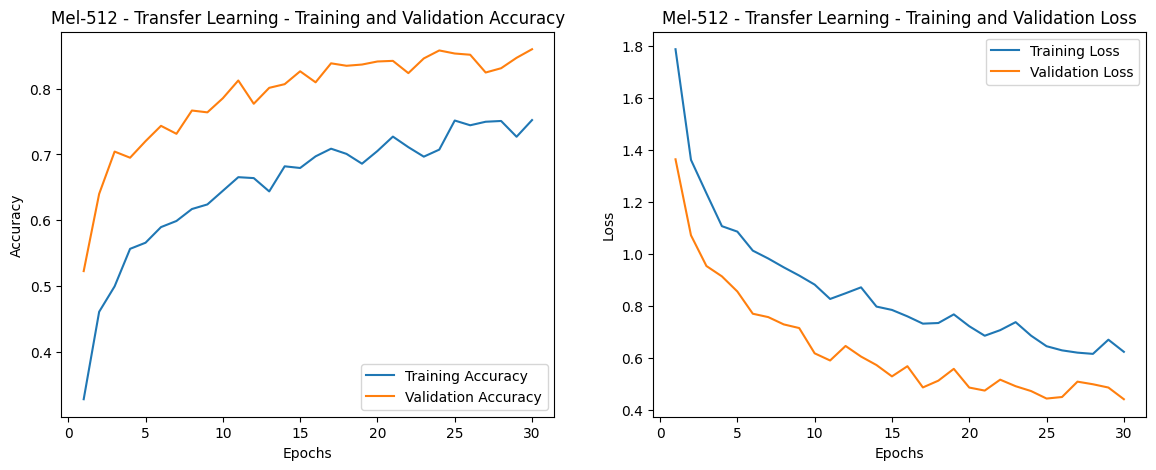

1/1 [==============================] - 0s 36ms/step

Reporte de Clasificación para Mel-512 - Transfer Learning:

                  precision    recall  f1-score   support

 air_conditioner       0.83      0.87      0.85       143
children_playing       0.70      0.87      0.78       133
        drilling       0.91      0.86      0.88       168
   engine_idling       0.88      0.86      0.87       150
      jackhammer       0.91      0.94      0.92       156
           siren       0.92      0.90      0.91       161
    street_music       0.88      0.73      0.80       161

        accuracy                           0.86      1072
       macro avg       0.86      0.86      0.86      1072
    weighted avg       0.87      0.86      0.86      1072



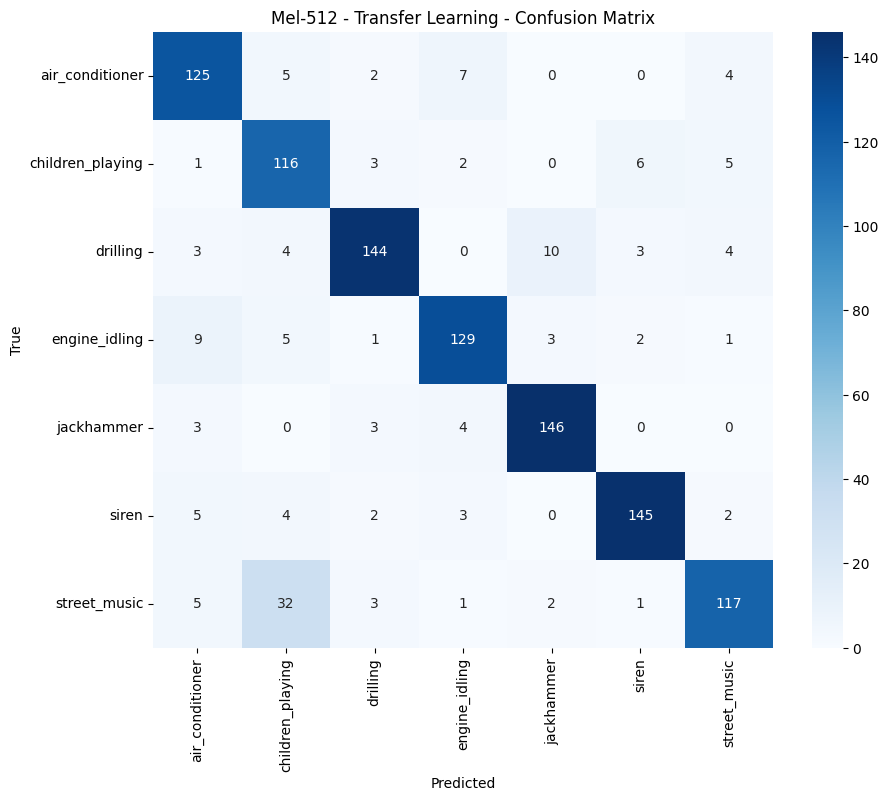

FLOPs para Mel-512 (Fine-Tuning): 84628140
Epoch 1/60
86/86 [==============================] - 45s 428ms/step - loss: 0.6039 - accuracy: 0.7618 - val_loss: 0.4589 - val_accuracy: 0.8545
Epoch 2/60
86/86 [==============================] - 32s 368ms/step - loss: 0.5614 - accuracy: 0.7688 - val_loss: 0.4760 - val_accuracy: 0.8647
Epoch 3/60
86/86 [==============================] - 35s 391ms/step - loss: 0.5251 - accuracy: 0.7863 - val_loss: 0.5078 - val_accuracy: 0.8498
Epoch 4/60
86/86 [==============================] - 32s 367ms/step - loss: 0.5342 - accuracy: 0.7732 - val_loss: 0.4874 - val_accuracy: 0.8554
Epoch 5/60
86/86 [==============================] - 34s 381ms/step - loss: 0.4730 - accuracy: 0.8068 - val_loss: 0.3836 - val_accuracy: 0.8890
Epoch 6/60
86/86 [==============================] - 34s 389ms/step - loss: 0.4775 - accuracy: 0.8024 - val_loss: 0.3815 - val_accuracy: 0.8899
Epoch 7/60
86/86 [==============================] - 34s 383ms/step - loss: 0.4619 - accuracy: 0.802

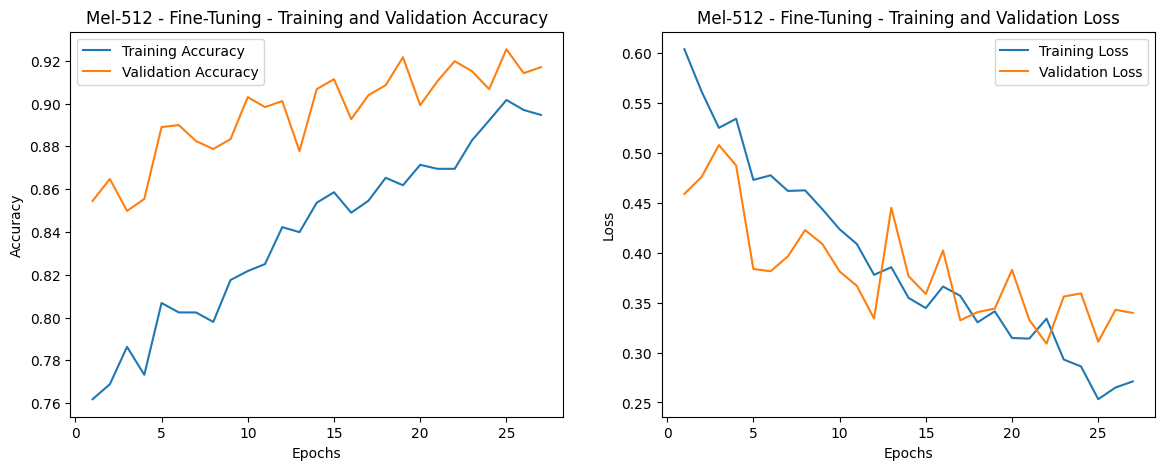

1/1 [==============================] - 0s 49ms/step

Reporte de Clasificación para Mel-512 - Fine-Tuning:

                  precision    recall  f1-score   support

 air_conditioner       0.92      0.92      0.92       143
children_playing       0.90      0.86      0.88       133
        drilling       0.90      0.93      0.92       168
   engine_idling       0.91      0.95      0.93       150
      jackhammer       0.93      0.94      0.94       156
           siren       0.95      0.96      0.95       161
    street_music       0.93      0.86      0.90       161

        accuracy                           0.92      1072
       macro avg       0.92      0.92      0.92      1072
    weighted avg       0.92      0.92      0.92      1072



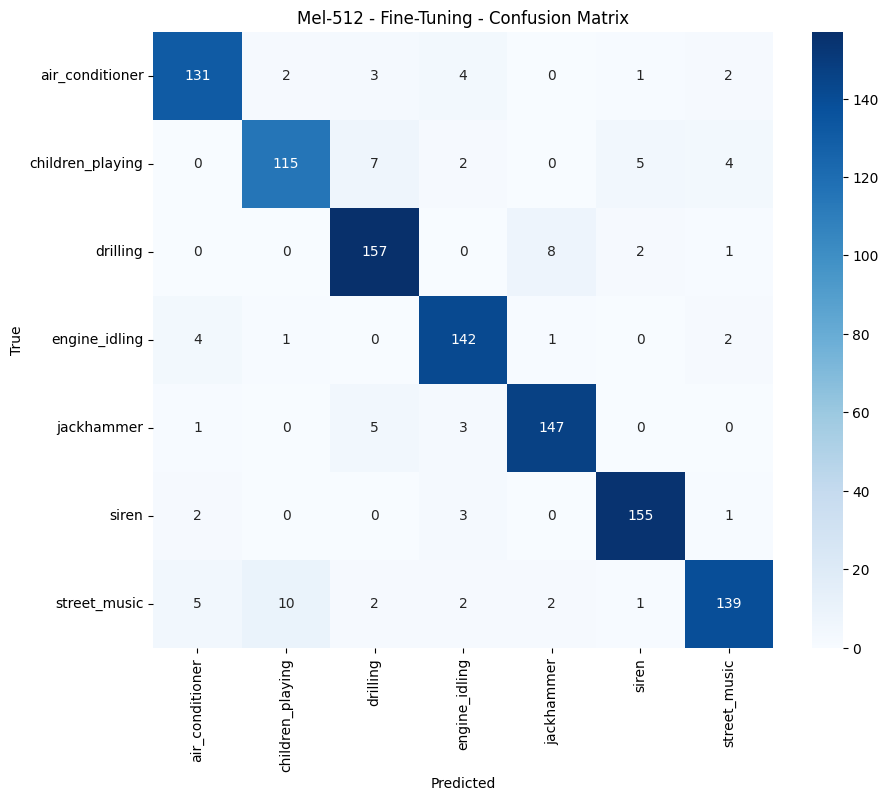

Tiempo Transfer Learning para Mel-512: 634.95 segundos
Tiempo Fine-Tuning para Mel-512: 907.60 segundos

Procesando representación: Mel-1024
Found 5363 files belonging to 7 classes.
Using 4291 files for training.
Found 5363 files belonging to 7 classes.
Using 1072 files for validation.
FLOPs para Mel-1024 (Transfer Learning): 84628140
Epoch 1/30
86/86 [==============================] - 20s 219ms/step - loss: 1.7780 - accuracy: 0.3435 - val_loss: 1.2620 - val_accuracy: 0.5896
Epoch 2/30
86/86 [==============================] - 20s 227ms/step - loss: 1.3165 - accuracy: 0.4724 - val_loss: 1.0817 - val_accuracy: 0.6782
Epoch 3/30
86/86 [==============================] - 21s 233ms/step - loss: 1.1412 - accuracy: 0.5437 - val_loss: 0.8420 - val_accuracy: 0.7453
Epoch 4/30
86/86 [==============================] - 20s 227ms/step - loss: 1.0386 - accuracy: 0.5917 - val_loss: 0.8174 - val_accuracy: 0.7155
Epoch 5/30
86/86 [==============================] - 21s 233ms/step - loss: 0.9841 - accurac

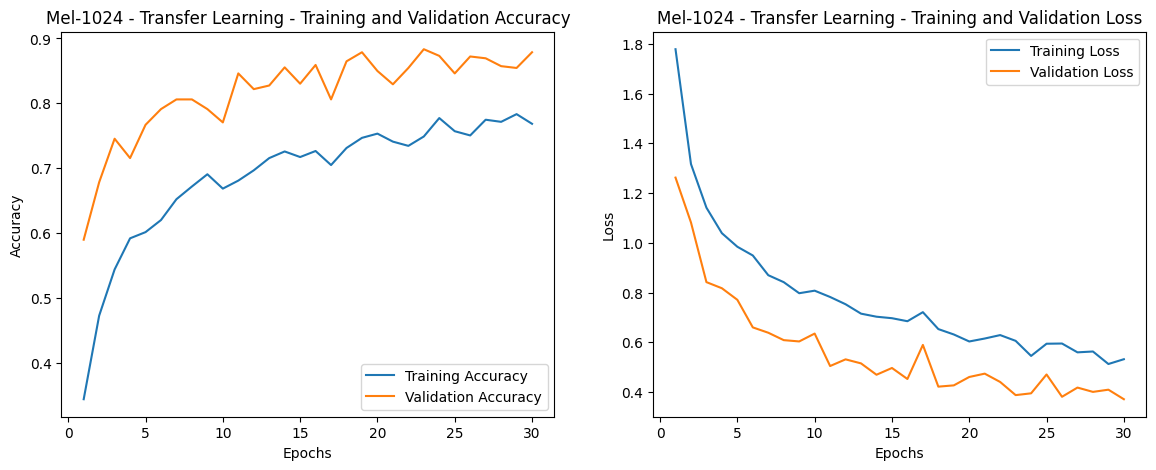

1/1 [==============================] - 0s 65ms/step

Reporte de Clasificación para Mel-1024 - Transfer Learning:

                  precision    recall  f1-score   support

 air_conditioner       0.84      0.94      0.89       143
children_playing       0.79      0.84      0.82       133
        drilling       0.92      0.86      0.89       168
   engine_idling       0.91      0.85      0.88       150
      jackhammer       0.90      0.91      0.91       156
           siren       0.99      0.85      0.91       161
    street_music       0.81      0.89      0.85       161

        accuracy                           0.88      1072
       macro avg       0.88      0.88      0.88      1072
    weighted avg       0.88      0.88      0.88      1072



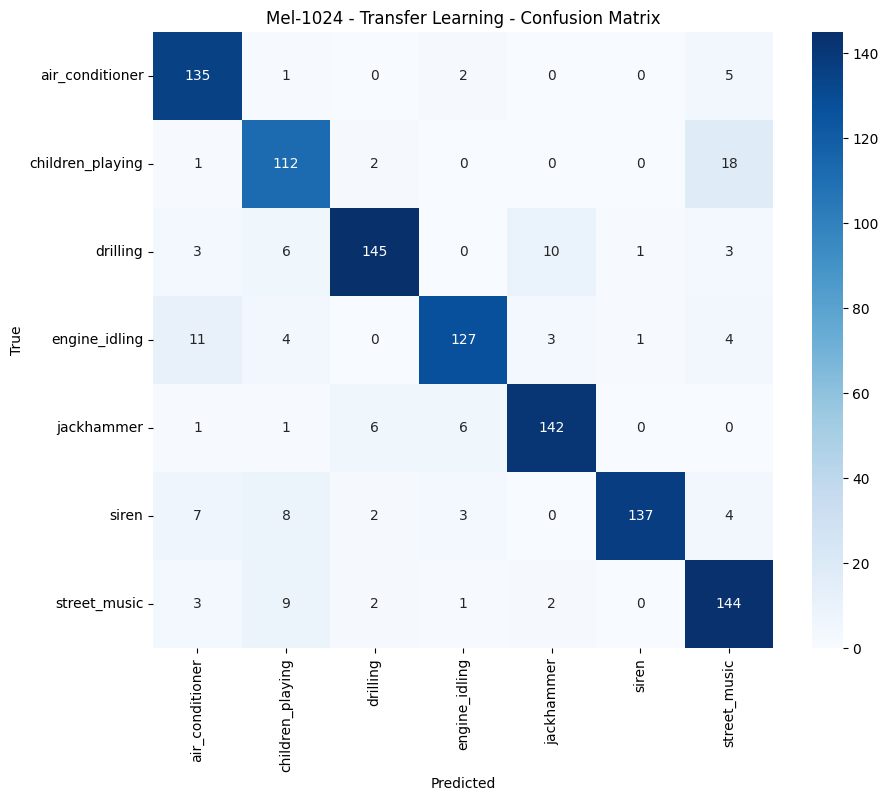

FLOPs para Mel-1024 (Fine-Tuning): 84628140
Epoch 1/60
86/86 [==============================] - 33s 375ms/step - loss: 0.5200 - accuracy: 0.7875 - val_loss: 0.3879 - val_accuracy: 0.8703
Epoch 2/60
86/86 [==============================] - 32s 371ms/step - loss: 0.4734 - accuracy: 0.8101 - val_loss: 0.3463 - val_accuracy: 0.8881
Epoch 3/60
86/86 [==============================] - 33s 379ms/step - loss: 0.4568 - accuracy: 0.8119 - val_loss: 0.3132 - val_accuracy: 0.9067
Epoch 4/60
86/86 [==============================] - 32s 364ms/step - loss: 0.4053 - accuracy: 0.8313 - val_loss: 0.2864 - val_accuracy: 0.9076
Epoch 5/60
86/86 [==============================] - 33s 372ms/step - loss: 0.3671 - accuracy: 0.8499 - val_loss: 0.2723 - val_accuracy: 0.9114
Epoch 6/60
86/86 [==============================] - 32s 370ms/step - loss: 0.3772 - accuracy: 0.8443 - val_loss: 0.3529 - val_accuracy: 0.8834
Epoch 7/60
86/86 [==============================] - 33s 376ms/step - loss: 0.3347 - accuracy: 0.85

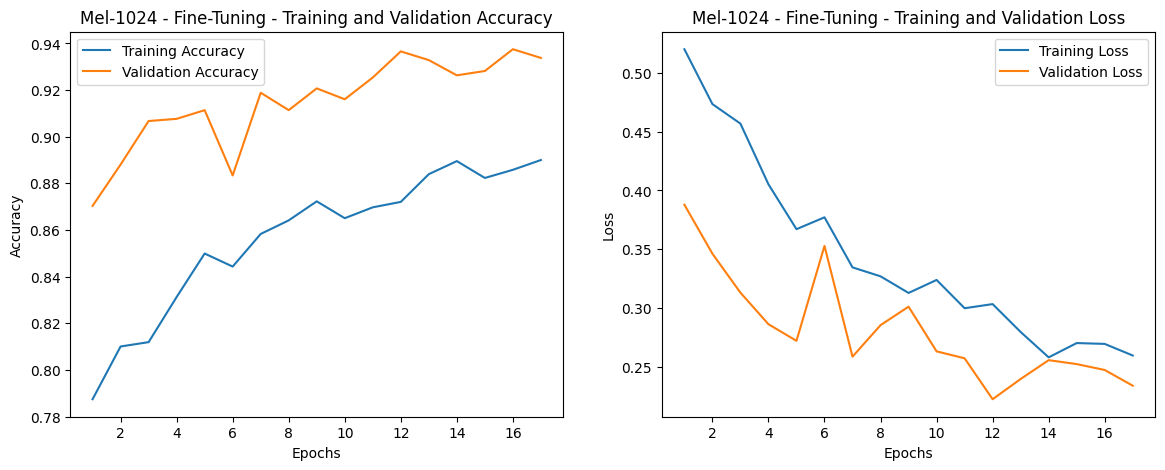

1/1 [==============================] - 0s 45ms/step

Reporte de Clasificación para Mel-1024 - Fine-Tuning:

                  precision    recall  f1-score   support

 air_conditioner       0.94      0.97      0.96       143
children_playing       0.93      0.89      0.91       133
        drilling       0.94      0.93      0.93       168
   engine_idling       0.92      0.93      0.93       150
      jackhammer       0.94      0.94      0.94       156
           siren       0.96      0.98      0.97       161
    street_music       0.93      0.91      0.92       161

        accuracy                           0.94      1072
       macro avg       0.94      0.94      0.94      1072
    weighted avg       0.94      0.94      0.94      1072



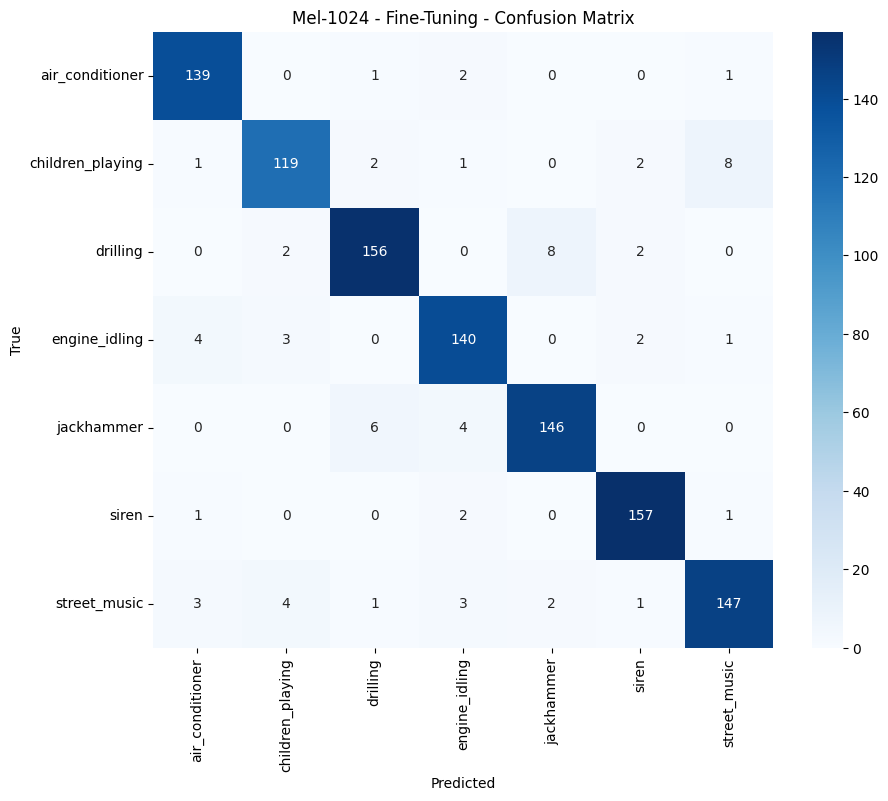

Tiempo Transfer Learning para Mel-1024: 633.19 segundos
Tiempo Fine-Tuning para Mel-1024: 561.58 segundos

Procesando representación: Mel-2048
Found 5365 files belonging to 7 classes.
Using 4292 files for training.
Found 5365 files belonging to 7 classes.
Using 1073 files for validation.
FLOPs para Mel-2048 (Transfer Learning): 84628140
Epoch 1/30
86/86 [==============================] - 29s 323ms/step - loss: 1.9734 - accuracy: 0.3229 - val_loss: 1.2905 - val_accuracy: 0.5517
Epoch 2/30
86/86 [==============================] - 21s 237ms/step - loss: 1.3302 - accuracy: 0.4793 - val_loss: 1.0357 - val_accuracy: 0.6468
Epoch 3/30
86/86 [==============================] - 21s 239ms/step - loss: 1.1936 - accuracy: 0.5443 - val_loss: 0.9370 - val_accuracy: 0.7111
Epoch 4/30
86/86 [==============================] - 22s 242ms/step - loss: 1.0612 - accuracy: 0.5836 - val_loss: 0.8063 - val_accuracy: 0.7782
Epoch 5/30
86/86 [==============================] - 21s 243ms/step - loss: 0.9792 - accur

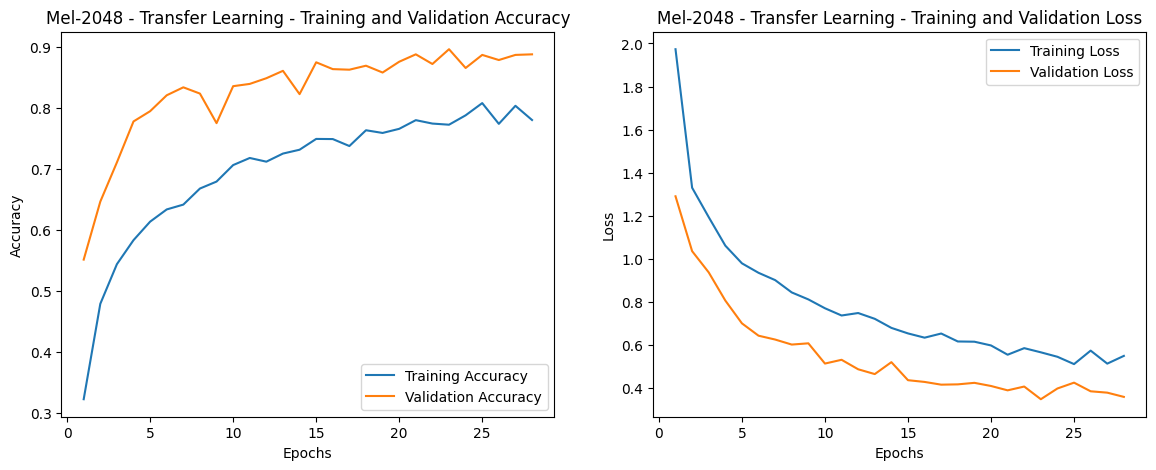

1/1 [==============================] - 0s 63ms/step

Reporte de Clasificación para Mel-2048 - Transfer Learning:

                  precision    recall  f1-score   support

 air_conditioner       0.89      0.93      0.91       143
children_playing       0.80      0.88      0.84       133
        drilling       0.94      0.90      0.92       169
   engine_idling       0.91      0.90      0.90       150
      jackhammer       0.95      0.92      0.94       157
           siren       0.92      0.88      0.90       161
    street_music       0.87      0.88      0.87       160

        accuracy                           0.90      1073
       macro avg       0.90      0.90      0.90      1073
    weighted avg       0.90      0.90      0.90      1073



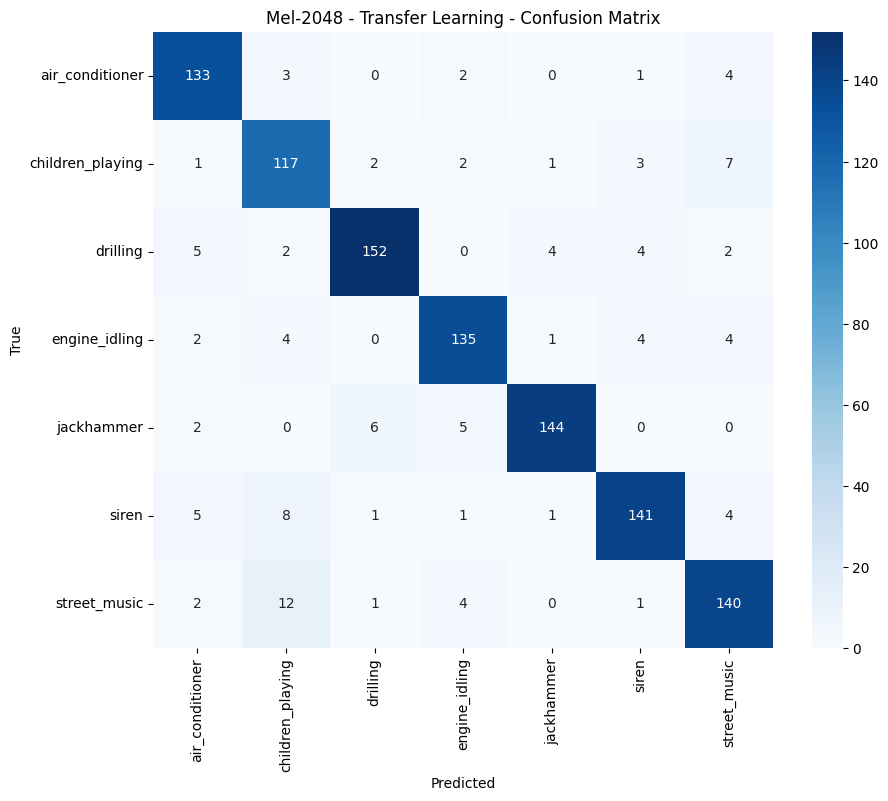

FLOPs para Mel-2048 (Fine-Tuning): 84628140
Epoch 1/60
86/86 [==============================] - 37s 420ms/step - loss: 0.5471 - accuracy: 0.7894 - val_loss: 0.3306 - val_accuracy: 0.9031
Epoch 2/60
86/86 [==============================] - 32s 361ms/step - loss: 0.4641 - accuracy: 0.8283 - val_loss: 0.3688 - val_accuracy: 0.8751
Epoch 3/60
86/86 [==============================] - 32s 365ms/step - loss: 0.4606 - accuracy: 0.8206 - val_loss: 0.3254 - val_accuracy: 0.8956
Epoch 4/60
86/86 [==============================] - 32s 369ms/step - loss: 0.4190 - accuracy: 0.8388 - val_loss: 0.3491 - val_accuracy: 0.9003
Epoch 5/60
86/86 [==============================] - 33s 372ms/step - loss: 0.3917 - accuracy: 0.8551 - val_loss: 0.2865 - val_accuracy: 0.9124
Epoch 6/60
86/86 [==============================] - 32s 366ms/step - loss: 0.4080 - accuracy: 0.8462 - val_loss: 0.2526 - val_accuracy: 0.9226
Epoch 7/60
86/86 [==============================] - 32s 368ms/step - loss: 0.3764 - accuracy: 0.85

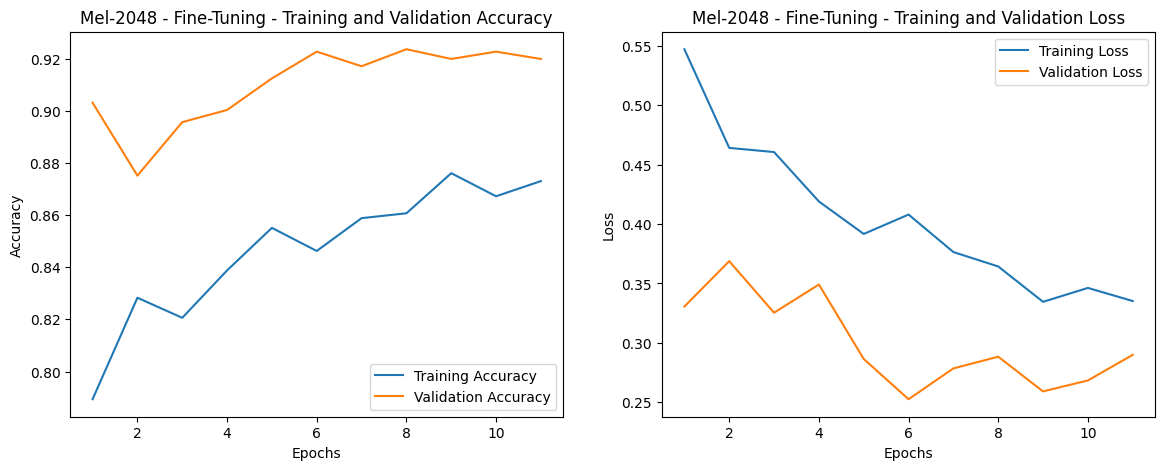

1/1 [==============================] - 0s 181ms/step

Reporte de Clasificación para Mel-2048 - Fine-Tuning:

                  precision    recall  f1-score   support

 air_conditioner       0.93      0.97      0.95       143
children_playing       0.90      0.80      0.85       133
        drilling       0.95      0.92      0.93       169
   engine_idling       0.91      0.95      0.93       150
      jackhammer       0.94      0.94      0.94       157
           siren       0.93      0.95      0.94       161
    street_music       0.90      0.91      0.90       160

        accuracy                           0.92      1073
       macro avg       0.92      0.92      0.92      1073
    weighted avg       0.92      0.92      0.92      1073



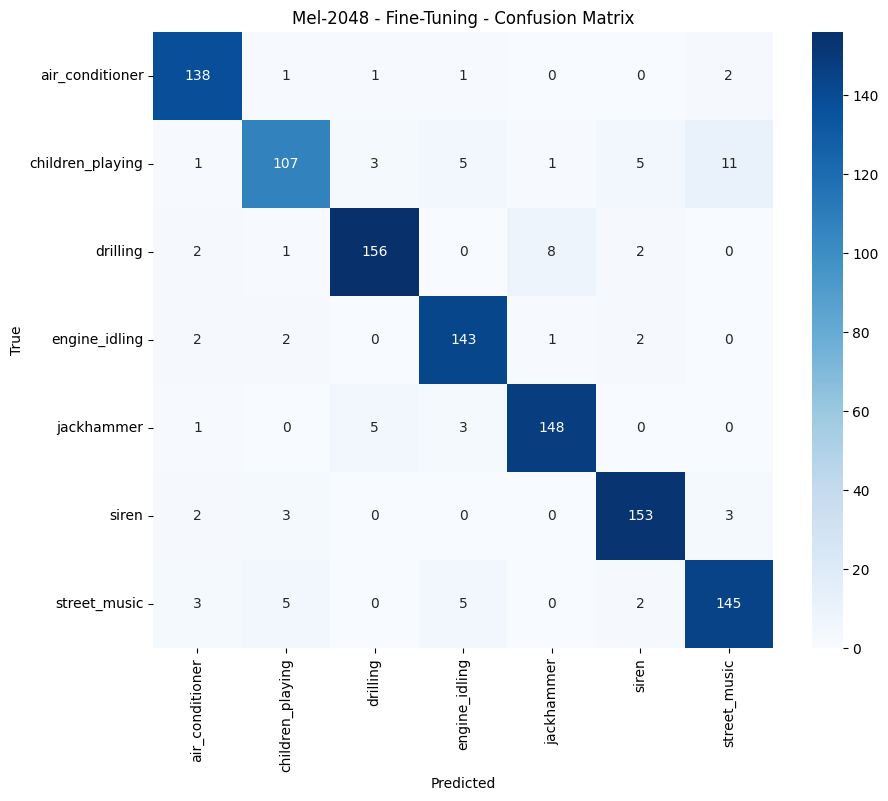

Tiempo Transfer Learning para Mel-2048: 594.55 segundos
Tiempo Fine-Tuning para Mel-2048: 363.86 segundos

Procesando representación: Bump
Found 5362 files belonging to 7 classes.
Using 4290 files for training.
Found 5362 files belonging to 7 classes.
Using 1072 files for validation.
FLOPs para Bump (Transfer Learning): 84628140
Epoch 1/30
86/86 [==============================] - 25s 284ms/step - loss: 2.0755 - accuracy: 0.2009 - val_loss: 1.8022 - val_accuracy: 0.2491
Epoch 2/30
86/86 [==============================] - 20s 229ms/step - loss: 1.7992 - accuracy: 0.2494 - val_loss: 1.6953 - val_accuracy: 0.3638
Epoch 3/30
86/86 [==============================] - 21s 236ms/step - loss: 1.7615 - accuracy: 0.2844 - val_loss: 1.6318 - val_accuracy: 0.3582
Epoch 4/30
86/86 [==============================] - 21s 234ms/step - loss: 1.7028 - accuracy: 0.3035 - val_loss: 1.5864 - val_accuracy: 0.4608
Epoch 5/30
86/86 [==============================] - 20s 229ms/step - loss: 1.6580 - accuracy: 0.3

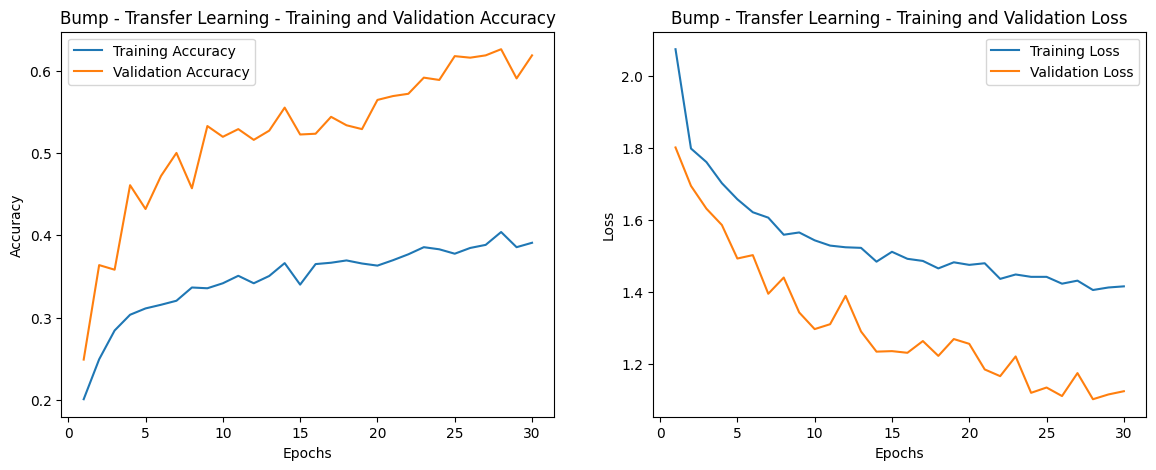

1/1 [==============================] - 0s 42ms/step

Reporte de Clasificación para Bump - Transfer Learning:

                  precision    recall  f1-score   support

 air_conditioner       0.48      0.75      0.58       143
children_playing       0.53      0.55      0.54       133
        drilling       0.94      0.65      0.77       168
  engine_idiling       0.36      0.27      0.31       149
      jackhammer       0.61      0.83      0.70       157
           siren       0.96      0.81      0.88       161
    street_music       0.55      0.45      0.49       161

        accuracy                           0.62      1072
       macro avg       0.63      0.62      0.61      1072
    weighted avg       0.64      0.62      0.62      1072



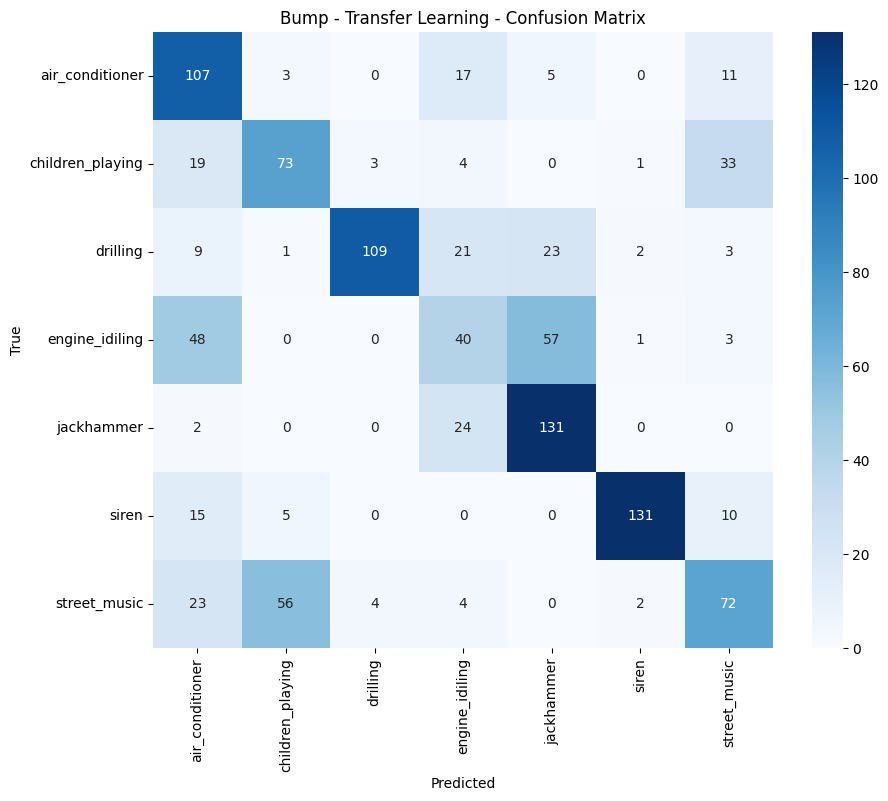

FLOPs para Bump (Fine-Tuning): 84628140
Epoch 1/60
86/86 [==============================] - 38s 427ms/step - loss: 1.4234 - accuracy: 0.3886 - val_loss: 1.1093 - val_accuracy: 0.6035
Epoch 2/60
86/86 [==============================] - 33s 374ms/step - loss: 1.3630 - accuracy: 0.4126 - val_loss: 1.0267 - val_accuracy: 0.6241
Epoch 3/60
86/86 [==============================] - 33s 384ms/step - loss: 1.3044 - accuracy: 0.4315 - val_loss: 1.0028 - val_accuracy: 0.6362
Epoch 4/60
86/86 [==============================] - 33s 380ms/step - loss: 1.2853 - accuracy: 0.4303 - val_loss: 0.9091 - val_accuracy: 0.6614
Epoch 5/60
86/86 [==============================] - 33s 383ms/step - loss: 1.2295 - accuracy: 0.4506 - val_loss: 0.9004 - val_accuracy: 0.7024
Epoch 6/60
86/86 [==============================] - 33s 380ms/step - loss: 1.1876 - accuracy: 0.4932 - val_loss: 0.8758 - val_accuracy: 0.7015
Epoch 7/60
86/86 [==============================] - 33s 376ms/step - loss: 1.0662 - accuracy: 0.5746 -

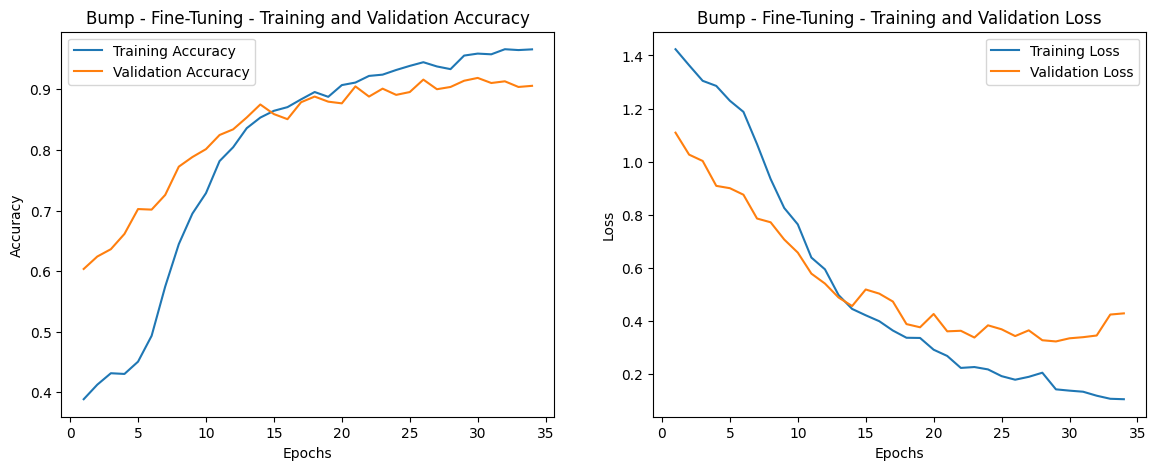

1/1 [==============================] - 0s 89ms/step

Reporte de Clasificación para Bump - Fine-Tuning:

                  precision    recall  f1-score   support

 air_conditioner       0.89      0.93      0.91       143
children_playing       0.89      0.78      0.83       133
        drilling       0.91      0.98      0.94       168
  engine_idiling       0.95      0.92      0.94       149
      jackhammer       0.97      0.95      0.96       157
           siren       0.97      0.90      0.93       161
    street_music       0.84      0.92      0.88       161

        accuracy                           0.91      1072
       macro avg       0.92      0.91      0.91      1072
    weighted avg       0.92      0.91      0.91      1072



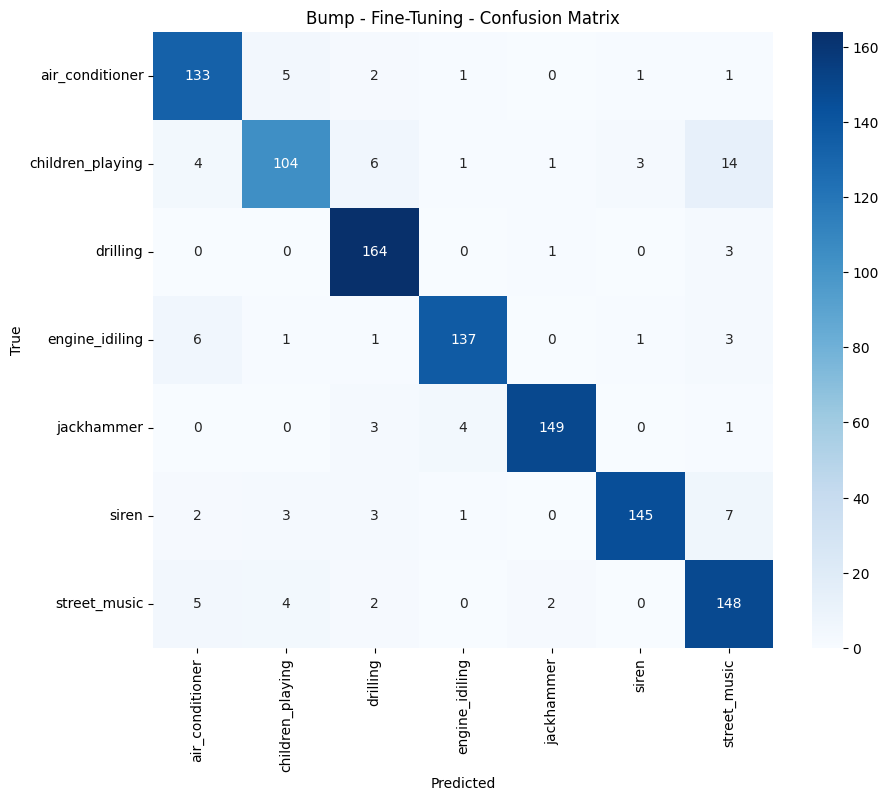

Tiempo Transfer Learning para Bump: 621.42 segundos
Tiempo Fine-Tuning para Bump: 1117.21 segundos

Procesando representación: Morlet
Found 5362 files belonging to 7 classes.
Using 4290 files for training.
Found 5362 files belonging to 7 classes.
Using 1072 files for validation.
FLOPs para Morlet (Transfer Learning): 84628140
Epoch 1/30
86/86 [==============================] - 21s 233ms/step - loss: 2.0097 - accuracy: 0.2464 - val_loss: 1.5873 - val_accuracy: 0.4506
Epoch 2/30
86/86 [==============================] - 20s 228ms/step - loss: 1.6364 - accuracy: 0.3282 - val_loss: 1.4379 - val_accuracy: 0.4403
Epoch 3/30
86/86 [==============================] - 21s 235ms/step - loss: 1.5137 - accuracy: 0.3767 - val_loss: 1.2951 - val_accuracy: 0.5821
Epoch 4/30
86/86 [==============================] - 20s 233ms/step - loss: 1.4344 - accuracy: 0.4182 - val_loss: 1.3164 - val_accuracy: 0.5625
Epoch 5/30
86/86 [==============================] - 21s 239ms/step - loss: 1.4162 - accuracy: 0.4214

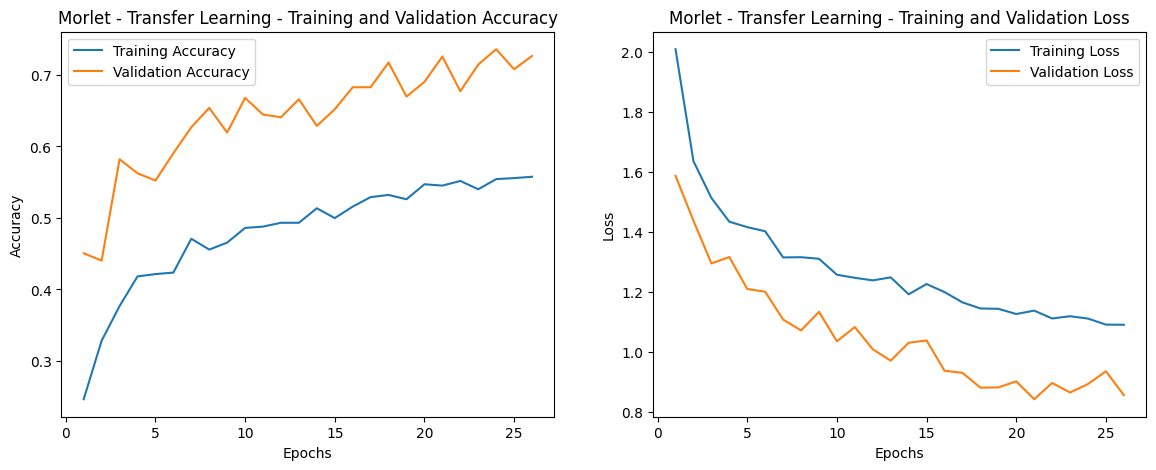

1/1 [==============================] - 0s 29ms/step

Reporte de Clasificación para Morlet - Transfer Learning:

                  precision    recall  f1-score   support

 air_conditioner       0.72      0.57      0.64       143
children_playing       0.65      0.69      0.67       133
        drilling       0.69      0.89      0.78       168
  engine_idiling       0.65      0.69      0.67       149
      jackhammer       0.77      0.62      0.69       157
           siren       0.89      0.81      0.85       161
    street_music       0.73      0.76      0.75       161

        accuracy                           0.73      1072
       macro avg       0.73      0.72      0.72      1072
    weighted avg       0.73      0.73      0.72      1072



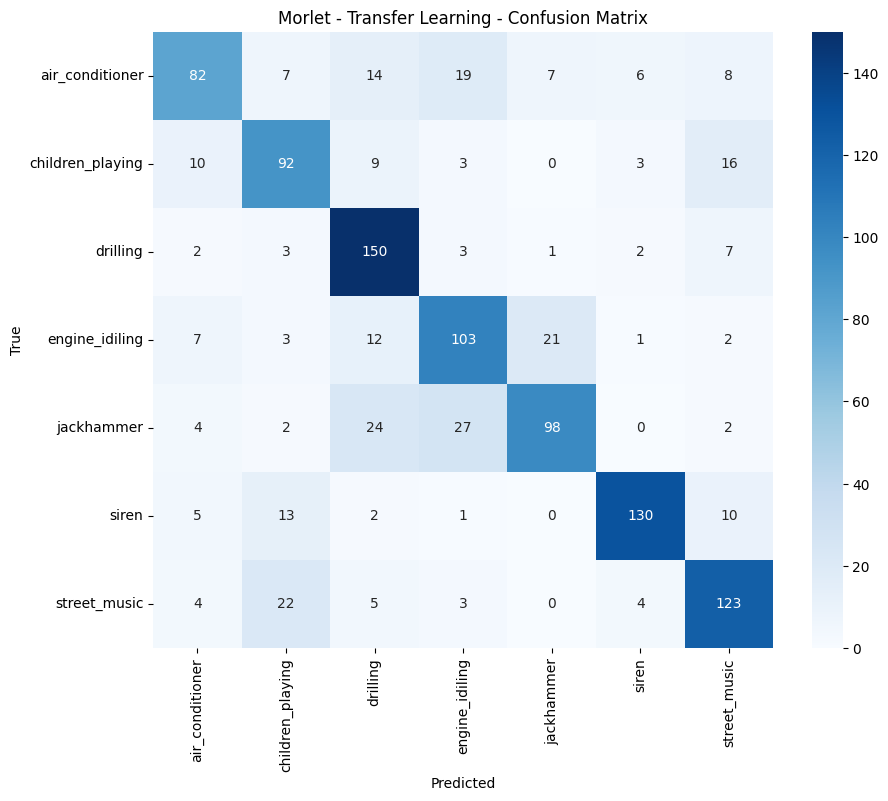

FLOPs para Morlet (Fine-Tuning): 84628140
Epoch 1/60
86/86 [==============================] - 32s 363ms/step - loss: 1.1211 - accuracy: 0.5555 - val_loss: 0.8353 - val_accuracy: 0.7323
Epoch 2/60
86/86 [==============================] - 32s 368ms/step - loss: 1.0157 - accuracy: 0.5907 - val_loss: 0.7117 - val_accuracy: 0.7817
Epoch 3/60
86/86 [==============================] - 32s 365ms/step - loss: 0.9985 - accuracy: 0.5972 - val_loss: 0.7043 - val_accuracy: 0.7724
Epoch 4/60
86/86 [==============================] - 32s 368ms/step - loss: 0.9324 - accuracy: 0.6226 - val_loss: 0.7079 - val_accuracy: 0.7799
Epoch 5/60
86/86 [==============================] - 33s 379ms/step - loss: 0.9161 - accuracy: 0.6242 - val_loss: 0.6064 - val_accuracy: 0.8125
Epoch 6/60
86/86 [==============================] - 32s 366ms/step - loss: 0.8946 - accuracy: 0.6364 - val_loss: 0.6148 - val_accuracy: 0.8209
Epoch 7/60
86/86 [==============================] - 33s 379ms/step - loss: 0.8506 - accuracy: 0.6534

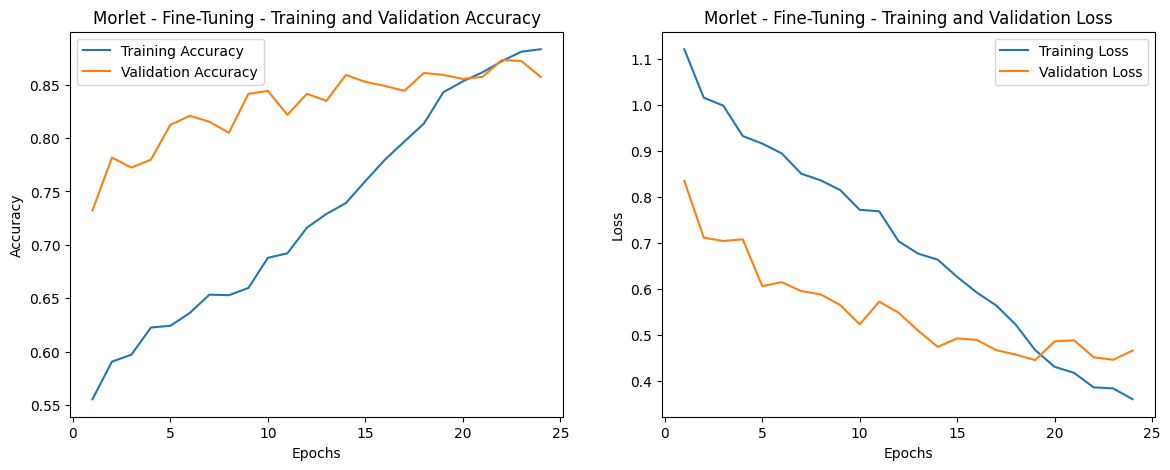

1/1 [==============================] - 0s 36ms/step

Reporte de Clasificación para Morlet - Fine-Tuning:

                  precision    recall  f1-score   support

 air_conditioner       0.70      0.90      0.79       143
children_playing       0.76      0.79      0.77       133
        drilling       0.92      0.93      0.93       168
  engine_idiling       0.88      0.80      0.84       149
      jackhammer       0.94      0.89      0.92       157
           siren       0.97      0.90      0.93       161
    street_music       0.88      0.79      0.83       161

        accuracy                           0.86      1072
       macro avg       0.86      0.86      0.86      1072
    weighted avg       0.87      0.86      0.86      1072



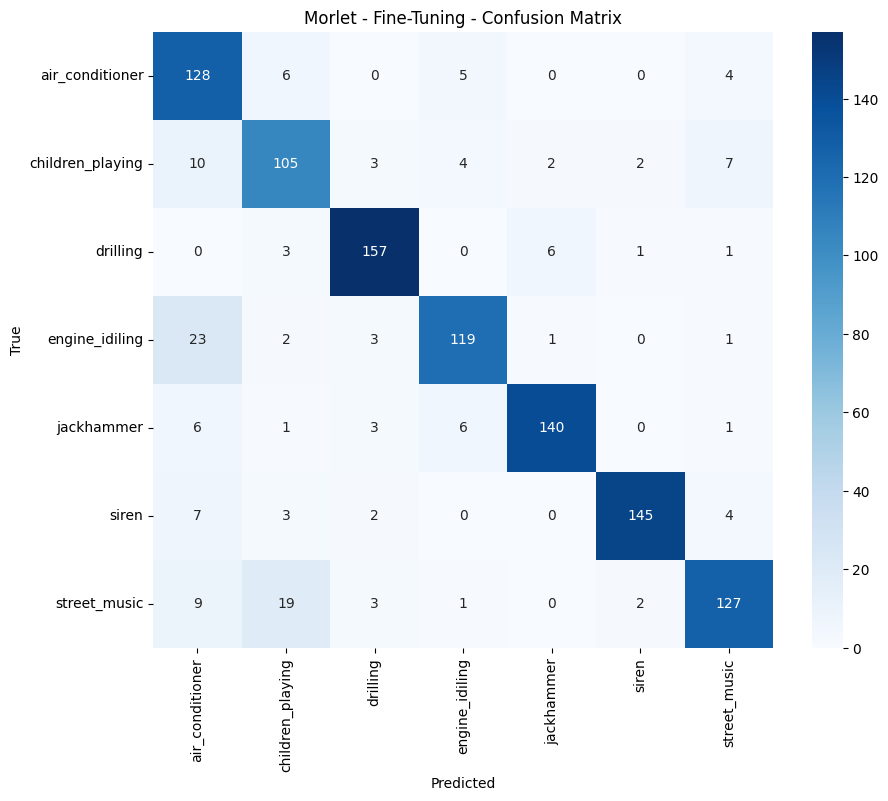

Tiempo Transfer Learning para Morlet: 550.46 segundos
Tiempo Fine-Tuning para Morlet: 786.47 segundos


In [13]:
# Iterar sobre cada representación
for representation, data_path in data_paths.items():
    print(f"\nProcesando representación: {representation}")

    # Cargar datos
    train_ds, val_ds, class_names = load_and_preprocess_data(data_path)
    num_classes = len(class_names)

    # Crear modelo base
    model = create_model(num_classes)

    # Medir carga computacional antes de Transfer Learning
    cpu_usages_tl, memory_usages_tl = [], []
    cpu_usages_ft, memory_usages_ft = [], []

    # **TRANSFER LEARNING**
    start_time_tl = time.time()

    # Medición de carga computacional antes del entrenamiento TL
    cpu, memory = measure_system_load()
    cpu_usages_tl.append(cpu)
    memory_usages_tl.append(memory)

    # Calcular FLOPs antes de TL
    flops_tl = get_flops(model)
    print(f"FLOPs para {representation} (Transfer Learning): {flops_tl}")

    # Entrenar con Transfer Learning
    history = train_model(model, train_ds, val_ds)
    plot_training_history(history, title=f"{representation} - Transfer Learning")

    # Medir tiempo final de TL
    end_time_tl = time.time()
    total_time_tl = end_time_tl - start_time_tl

    # Reporte de métricas
    report = generate_classification_report(model, val_ds, class_names, title=f"{representation} - Transfer Learning")

    # Guardar resultados TL
    final_results.append({
        "Representation": representation,
        "Stage": "Transfer Learning",
        "Accuracy": report["accuracy"],
        "Macro F1": report["macro avg"]["f1-score"],
        "Weighted F1": report["weighted avg"]["f1-score"],
        "FLOPs": flops_tl
    })

    # **FINE-TUNING**
    start_time_ft = time.time()

    # Medición de carga computacional antes del Fine-Tuning
    cpu, memory = measure_system_load()
    cpu_usages_ft.append(cpu)
    memory_usages_ft.append(memory)

    # Recalcular FLOPs si se desbloquean capas en Fine-Tuning
    flops_ft = get_flops(model)
    print(f"FLOPs para {representation} (Fine-Tuning): {flops_ft}")

    # Entrenar con Fine-Tuning
    fine_tune_history = fine_tune_model(model, train_ds, val_ds)
    plot_training_history(fine_tune_history, title=f"{representation} - Fine-Tuning")

    # Medir tiempo final de FT
    end_time_ft = time.time()
    total_time_ft = end_time_ft - start_time_ft

    # Reporte de métricas Fine-Tuning
    fine_tune_report = generate_classification_report(model, val_ds, class_names, title=f"{representation} - Fine-Tuning")

    # Guardar resultados FT
    final_results.append({
        "Representation": representation,
        "Stage": "Fine-Tuning",
        "Accuracy": fine_tune_report["accuracy"],
        "Macro F1": fine_tune_report["macro avg"]["f1-score"],
        "Weighted F1": fine_tune_report["weighted avg"]["f1-score"],
        "FLOPs": flops_ft
    })

    # Guardar modelo
    model.save(f"model_{representation}.keras")

    # Guardar tiempos de entrenamiento separados
    training_times.append({
        "Representation": representation,
        "Time TL (seconds)": total_time_tl,
        "Time FT (seconds)": total_time_ft
    })

    print(f"Tiempo Transfer Learning para {representation}: {total_time_tl:.2f} segundos")
    print(f"Tiempo Fine-Tuning para {representation}: {total_time_ft:.2f} segundos")

    # Guardar carga computacional separada por TL y FT
    computational_load.append({
        "Representation": representation,
        "CPU_TL (avg)": sum(cpu_usages_tl) / len(cpu_usages_tl),
        "Memory_TL (avg)": sum(memory_usages_tl) / len(memory_usages_tl),
        "CPU_FT (avg)": sum(cpu_usages_ft) / len(cpu_usages_ft),
        "Memory_FT (avg)": sum(memory_usages_ft) / len(memory_usages_ft),
    })

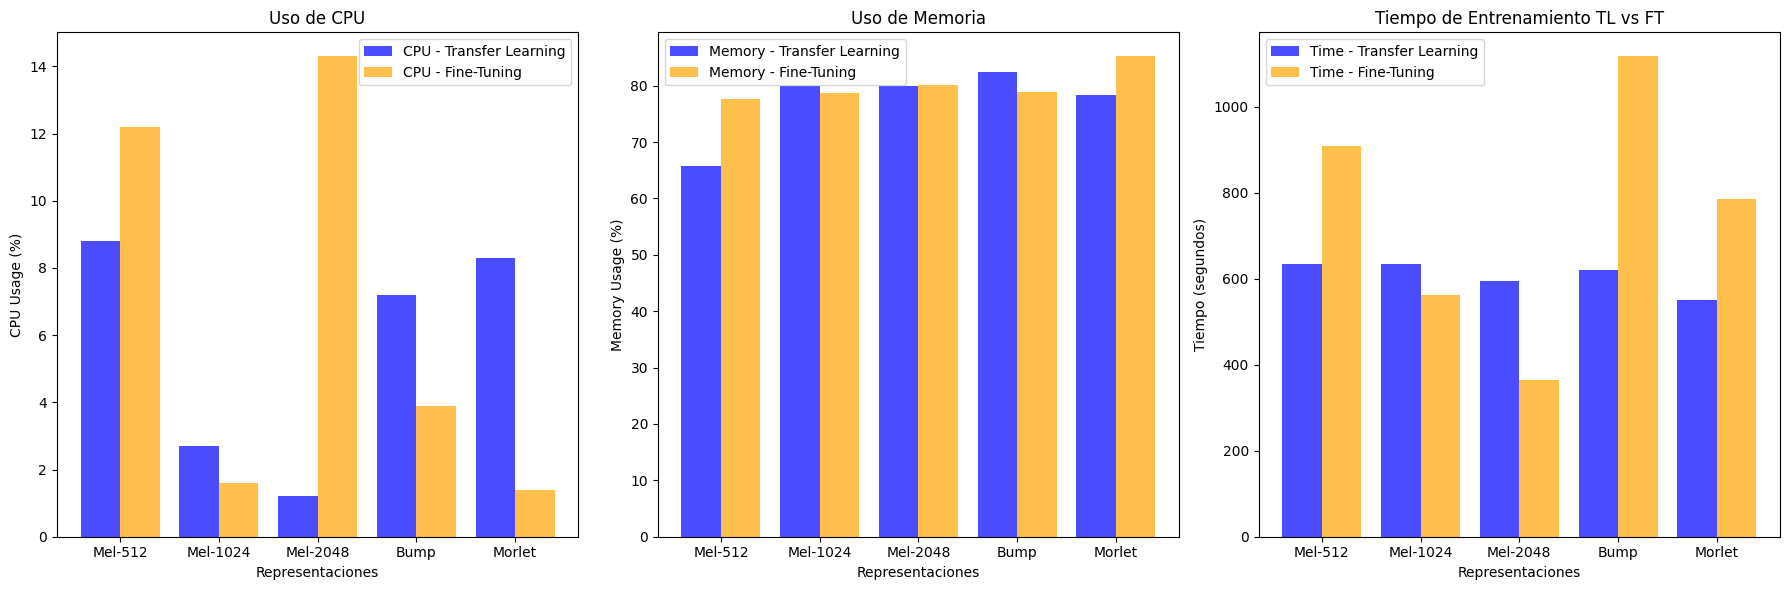

In [14]:
# **Gráficos de carga computacional y tiempos**
representations = [entry["Representation"] for entry in computational_load]
cpu_tl = [entry["CPU_TL (avg)"] for entry in computational_load]
memory_tl = [entry["Memory_TL (avg)"] for entry in computational_load]
cpu_ft = [entry["CPU_FT (avg)"] for entry in computational_load]
memory_ft = [entry["Memory_FT (avg)"] for entry in computational_load]
times_tl = [entry["Time TL (seconds)"] for entry in training_times]
times_ft = [entry["Time FT (seconds)"] for entry in training_times]

# Definir el tamaño de la figura
plt.figure(figsize=(18, 6))
 
# Crear posiciones para las barras
bar_width = 0.4
x_pos = range(len(representations))
 
# **Gráfico de Uso de CPU**
plt.subplot(1, 3, 1)
plt.bar(x_pos, cpu_tl, width=bar_width, label="CPU - Transfer Learning", color="blue", alpha=0.7)
plt.bar([x + bar_width for x in x_pos], cpu_ft, width=bar_width, label="CPU - Fine-Tuning", color="orange", alpha=0.7)
plt.ylabel('CPU Usage (%)')
plt.xlabel('Representaciones')
plt.xticks([x + bar_width / 2 for x in x_pos], representations)
plt.title('Uso de CPU')
plt.legend()
 
# **Gráfico de Uso de Memoria**
plt.subplot(1, 3, 2)
plt.bar(x_pos, memory_tl, width=bar_width, label="Memory - Transfer Learning", color="blue", alpha=0.7)
plt.bar([x + bar_width for x in x_pos], memory_ft, width=bar_width, label="Memory - Fine-Tuning", color="orange", alpha=0.7)
plt.ylabel('Memory Usage (%)')
plt.xlabel('Representaciones')
plt.xticks([x + bar_width / 2 for x in x_pos], representations)
plt.title('Uso de Memoria')
plt.legend()
 
# **Gráfico de Tiempos de Entrenamiento**
plt.subplot(1, 3, 3)
plt.bar(x_pos, times_tl, width=bar_width, label="Time - Transfer Learning", color="blue", alpha=0.7)
plt.bar([x + bar_width for x in x_pos], times_ft, width=bar_width, label="Time - Fine-Tuning", color="orange", alpha=0.7)
plt.ylabel('Tiempo (segundos)')
plt.xlabel('Representaciones')
plt.xticks([x + bar_width / 2 for x in x_pos], representations)
plt.title('Tiempo de Entrenamiento TL vs FT')
plt.legend()
 
plt.tight_layout()
plt.show()


In [15]:
# Crear DataFrame consolidado
df_results = pd.DataFrame(final_results)
# Mostrar el reporte completo
print("\n**Reporte Consolidado:**\n")
print(df_results)

# Calcular puntaje combinado (promedio de todas las métricas)
df_results["Average Score"] = df_results[["Accuracy", "Macro F1", "Weighted F1"]].mean(axis=1)

# Determinar el mejor modelo en base al puntaje combinado
best_model = df_results.sort_values(by="Average Score", ascending=False).iloc[0]

# Mostrar el mejor modelo
print("\n**Mejor Representación (Basado en Todas las Métricas):**")
print(best_model)


**Reporte Consolidado:**

  Representation              Stage  Accuracy  Macro F1  Weighted F1     FLOPs
0        Mel-512  Transfer Learning  0.860075  0.858617     0.860653  84628140
1        Mel-512        Fine-Tuning  0.919776  0.918638     0.919476  84628140
2       Mel-1024  Transfer Learning  0.878731  0.878159     0.879524  84628140
3       Mel-1024        Fine-Tuning  0.936567  0.936024     0.936410  84628140
4       Mel-2048  Transfer Learning  0.896552  0.895797     0.897054  84628140
5       Mel-2048        Fine-Tuning  0.922647  0.920684     0.922071  84628140
6           Bump  Transfer Learning  0.618470  0.610429     0.616792  84628140
7           Bump        Fine-Tuning  0.914179  0.912048     0.913949  84628140
8         Morlet  Transfer Learning  0.725746  0.720296     0.724100  84628140
9         Morlet        Fine-Tuning  0.859142  0.857027     0.860900  84628140

**Mejor Representación (Basado en Todas las Métricas):**
Representation       Mel-1024
Stage           

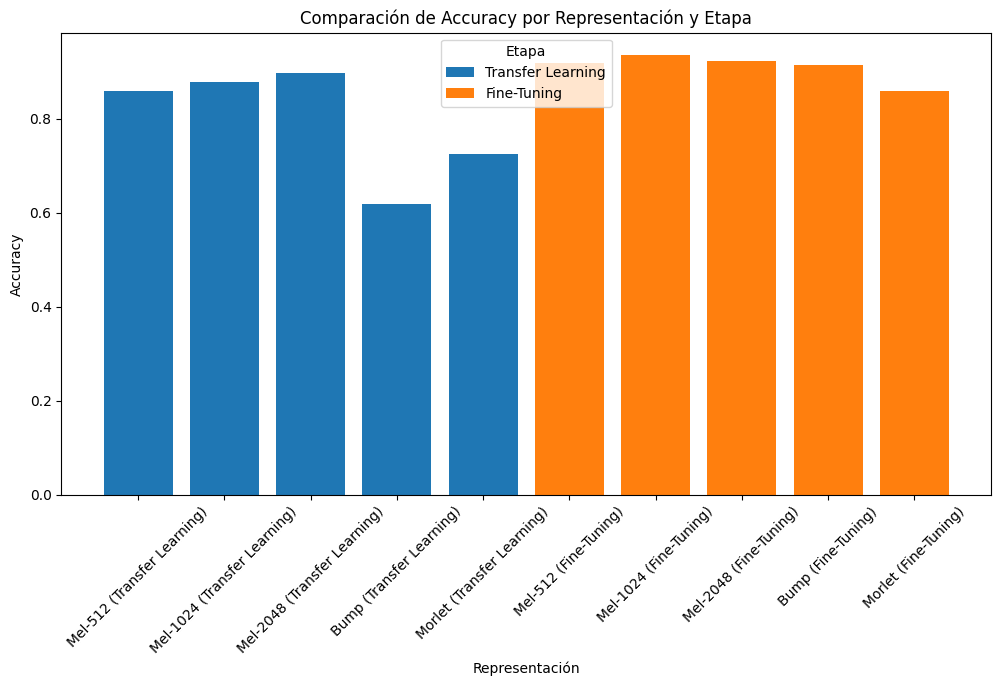

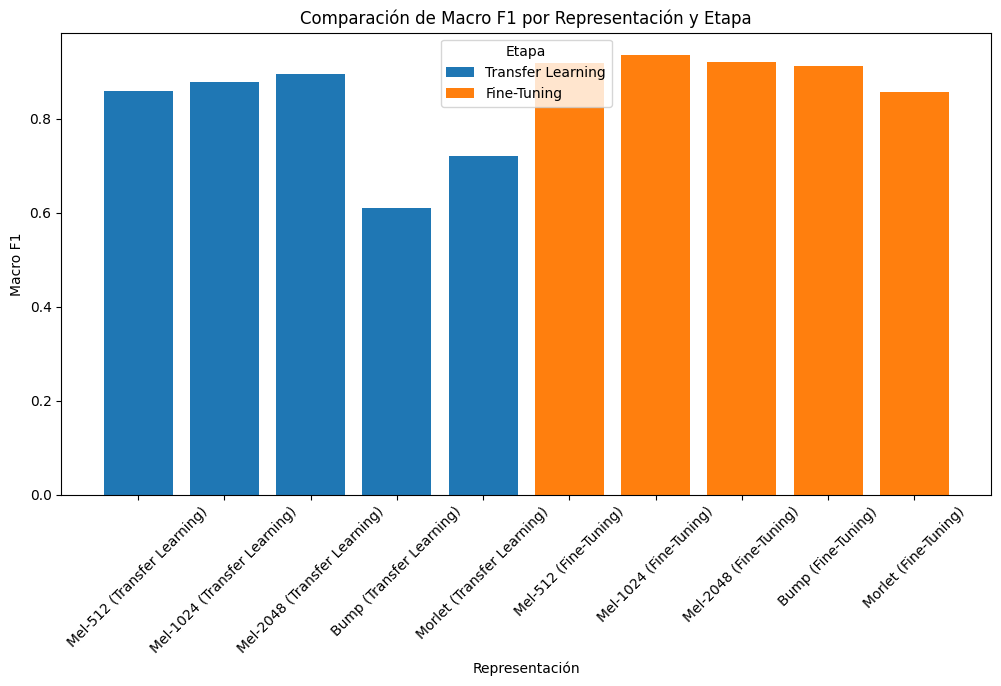

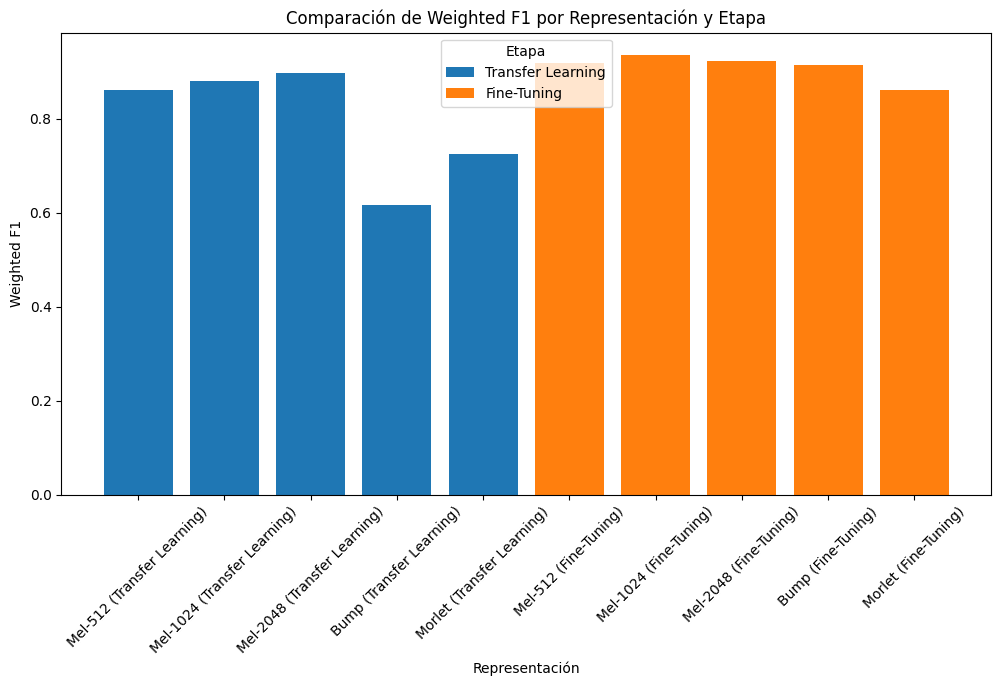

In [16]:
# Gráficos comparativos por métrica
metrics = ["Accuracy", "Macro F1", "Weighted F1"]
for metric in metrics:
    plt.figure(figsize=(12, 6))
    for stage in df_results["Stage"].unique():
        stage_data = df_results[df_results["Stage"] == stage]
        plt.bar(stage_data["Representation"] + f" ({stage})", stage_data[metric], label=stage)

    plt.title(f"Comparación de {metric} por Representación y Etapa")
    plt.xlabel("Representación")
    plt.ylabel(metric)
    plt.xticks(rotation=45)
    plt.legend(title="Etapa")
    plt.show()

In [17]:
# Ordenar resultados por puntaje promedio
df_results_sorted = df_results.sort_values(by="Average Score", ascending=False)

# Mostrar la tabla final ordenada
print("\n**Tabla de Resultados Ordenada por Puntaje Promedio:**\n")
print(df_results_sorted)


**Tabla de Resultados Ordenada por Puntaje Promedio:**

  Representation              Stage  Accuracy  Macro F1  Weighted F1  \
3       Mel-1024        Fine-Tuning  0.936567  0.936024     0.936410   
5       Mel-2048        Fine-Tuning  0.922647  0.920684     0.922071   
1        Mel-512        Fine-Tuning  0.919776  0.918638     0.919476   
7           Bump        Fine-Tuning  0.914179  0.912048     0.913949   
4       Mel-2048  Transfer Learning  0.896552  0.895797     0.897054   
2       Mel-1024  Transfer Learning  0.878731  0.878159     0.879524   
0        Mel-512  Transfer Learning  0.860075  0.858617     0.860653   
9         Morlet        Fine-Tuning  0.859142  0.857027     0.860900   
8         Morlet  Transfer Learning  0.725746  0.720296     0.724100   
6           Bump  Transfer Learning  0.618470  0.610429     0.616792   

      FLOPs  Average Score  
3  84628140       0.936334  
5  84628140       0.921801  
1  84628140       0.919297  
7  84628140       0.913392  
4  84

In [18]:
from pprint import pformat

with open("resultados.txt", "w") as archivo:
    archivo.write("=== Resultados Finales ===\n")
    archivo.write(pformat(final_results, indent=4))
    
    archivo.write("\n\n=== Carga Computacional ===\n")
    archivo.write(pformat(computational_load, indent=4))
    
    archivo.write("\n\n=== Tiempos de Entrenamiento ===\n")
    archivo.write(pformat(training_times, indent=4))